In [4]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dqn.config import Config

In [5]:
def load_data(folder='results'):
    data = {}
    test_types = os.listdir(folder)
    for test_type in test_types:
        path = f'{folder}/{test_type}/deals_history.pkl'
        with open(path, 'rb') as f:
            result = processing_data(pickle.load(f))
            data[test_type] = result
    return data


def processing_data(data):
    data = (pd.DataFrame(data)
        .dropna()
        .assign(balance_profit = lambda _df: 100 * (_df.close_balance-_df.entry_balance) / _df.close_balance)
        .assign(profit = lambda _df: 100 * (_df.close_price-_df.entry_price) / _df.close_price)
    )
    return data

In [6]:
data = load_data()
test_types = list(data)
test_types.sort()

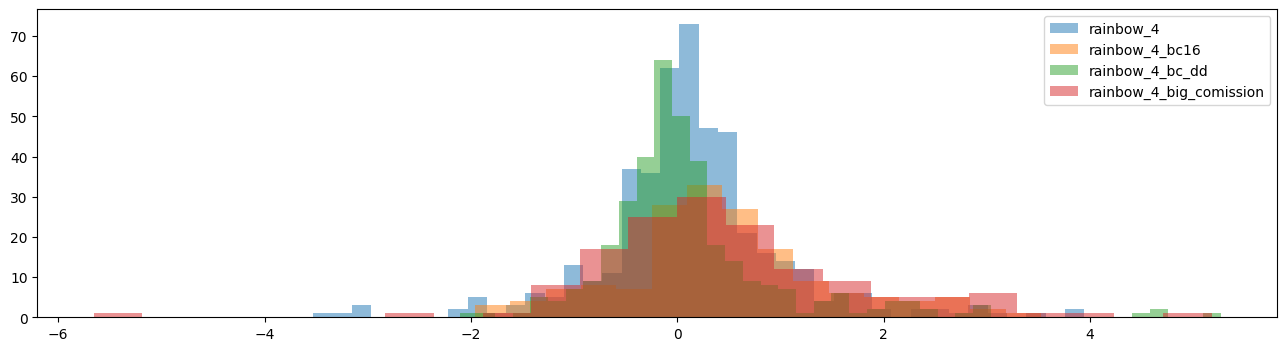

In [7]:
using_results = ['rainbow_4', 'rainbow_4_big_comission', 'rainbow_4_bc_dd', 'rainbow_4_bc16']
plt.figure(figsize=(16,4))
for test_type in test_types:
    if test_type not in using_results:
        continue
    plt.hist(data[test_type].profit, bins='auto', label=test_type, alpha=0.5)
plt.legend()

In [8]:
for test_type in test_types:
    print(f'{test_type} avg profit: {data[test_type].profit.mean():.3f}')

base_dqn avg profit: 0.115
double_dqn avg profit: 0.063
dueling_dqn avg profit: 0.084
rainbow_2 avg profit: 0.056
rainbow_3 avg profit: 0.049
rainbow_4 avg profit: 0.137
rainbow_4_bc16 avg profit: 0.446
rainbow_4_bc_dd avg profit: 0.120
rainbow_4_bc_tpsl avg profit: 0.101
rainbow_4_big_comission avg profit: 0.465


In [9]:
for test_type in test_types:
    print(f'{test_type} median profit: {data[test_type].profit.median():.3f}')

base_dqn median profit: 0.084
double_dqn median profit: 0.041
dueling_dqn median profit: 0.120
rainbow_2 median profit: 0.115
rainbow_3 median profit: 0.039
rainbow_4 median profit: 0.107
rainbow_4_bc16 median profit: 0.353
rainbow_4_bc_dd median profit: -0.054
rainbow_4_bc_tpsl median profit: 0.336
rainbow_4_big_comission median profit: 0.243


In [10]:
for test_type in test_types:
    print(f'{test_type} median balance profit: {data[test_type].balance_profit.mean():.3f}')

base_dqn median balance profit: 0.015
double_dqn median balance profit: -0.037
dueling_dqn median balance profit: -0.016
rainbow_2 median balance profit: -0.043
rainbow_3 median balance profit: -0.050
rainbow_4 median balance profit: 0.036
rainbow_4_bc16 median balance profit: 0.048
rainbow_4_bc_dd median balance profit: -0.278
rainbow_4_bc_tpsl median balance profit: -0.296
rainbow_4_big_comission median balance profit: 0.066


In [11]:
clip_value = 0.5
for test_type in test_types:
    print(f'Clip [-{clip_value}, {clip_value}] {test_type} avg profit: {data[test_type].profit.mean():.3f}')

# print(f'Clip [-{clip_value}, {clip_value}] Base avg profit: {base_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Double avg profit: {double_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Dueling avg profit: {dueling_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Rainbow2 avg profit: {rainbow2_results.profit.clip(-clip_value,clip_value).mean():.3f}')

Clip [-0.5, 0.5] base_dqn avg profit: 0.115
Clip [-0.5, 0.5] double_dqn avg profit: 0.063
Clip [-0.5, 0.5] dueling_dqn avg profit: 0.084
Clip [-0.5, 0.5] rainbow_2 avg profit: 0.056
Clip [-0.5, 0.5] rainbow_3 avg profit: 0.049
Clip [-0.5, 0.5] rainbow_4 avg profit: 0.137
Clip [-0.5, 0.5] rainbow_4_bc16 avg profit: 0.446
Clip [-0.5, 0.5] rainbow_4_bc_dd avg profit: 0.120
Clip [-0.5, 0.5] rainbow_4_bc_tpsl avg profit: 0.101
Clip [-0.5, 0.5] rainbow_4_big_comission avg profit: 0.465


In [12]:
for test_type in test_types:
    print(f'{test_type} std profit: {data[test_type].profit.std():.3f}')

base_dqn std profit: 0.812
double_dqn std profit: 0.775
dueling_dqn std profit: 0.750
rainbow_2 std profit: 1.127
rainbow_3 std profit: 0.690
rainbow_4 std profit: 0.893
rainbow_4_bc16 std profit: 1.005
rainbow_4_bc_dd std profit: 0.900
rainbow_4_bc_tpsl std profit: 1.473
rainbow_4_big_comission std profit: 1.298


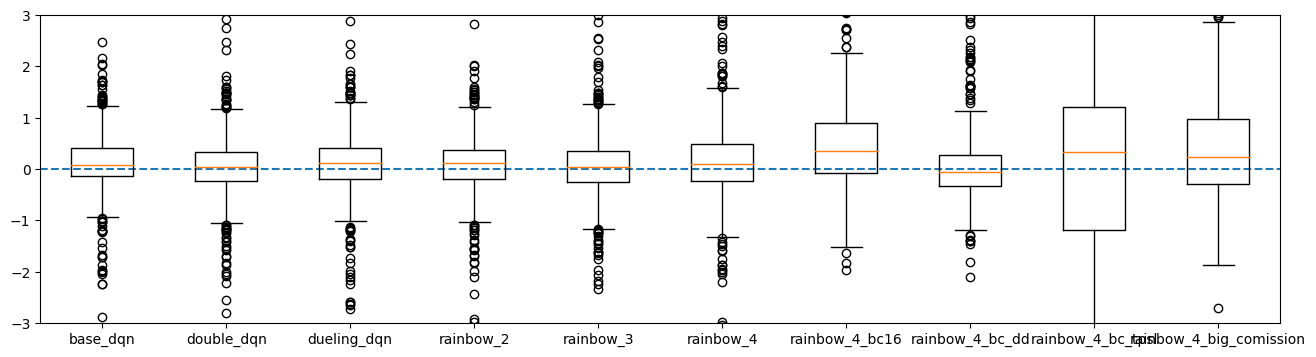

In [13]:
plt.figure(figsize=(16,4))
plt.axhline(0, linestyle='--')
plt.boxplot([data[test_type].profit.values for test_type in test_types], labels=test_types)
plt.ylim(-3,3)
# plt.legend()
print()

In [14]:
for test_type in test_types:
    coef = np.corrcoef(data[test_type].profit, data[test_type].predict_q)
    print(f'{test_type} corr coef with profit and Q value: {coef[0, 1]:.3f}')

base_dqn corr coef with profit and Q value: -0.004
double_dqn corr coef with profit and Q value: 0.023
dueling_dqn corr coef with profit and Q value: 0.042
rainbow_2 corr coef with profit and Q value: 0.092
rainbow_3 corr coef with profit and Q value: 0.040
rainbow_4 corr coef with profit and Q value: -0.051
rainbow_4_bc16 corr coef with profit and Q value: -0.053
rainbow_4_bc_dd corr coef with profit and Q value: -0.077
rainbow_4_bc_tpsl corr coef with profit and Q value: 0.012
rainbow_4_big_comission corr coef with profit and Q value: -0.025


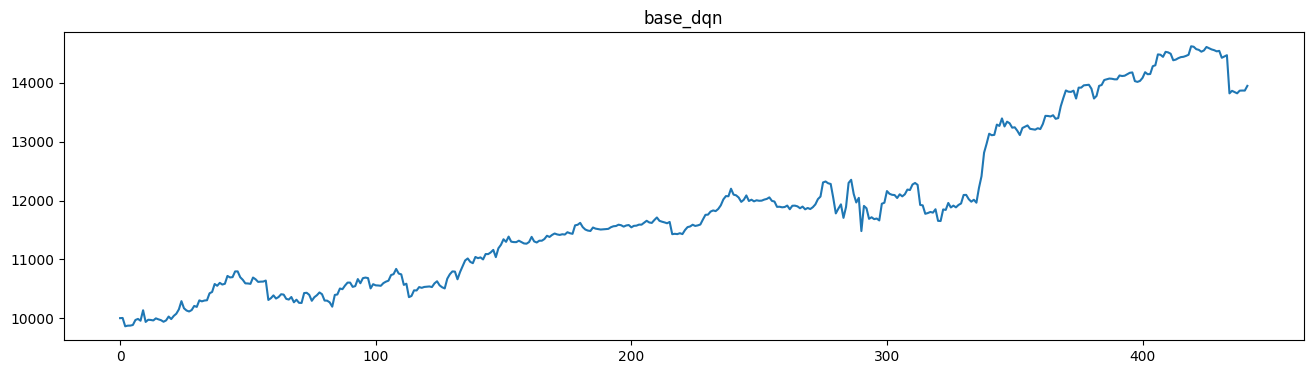

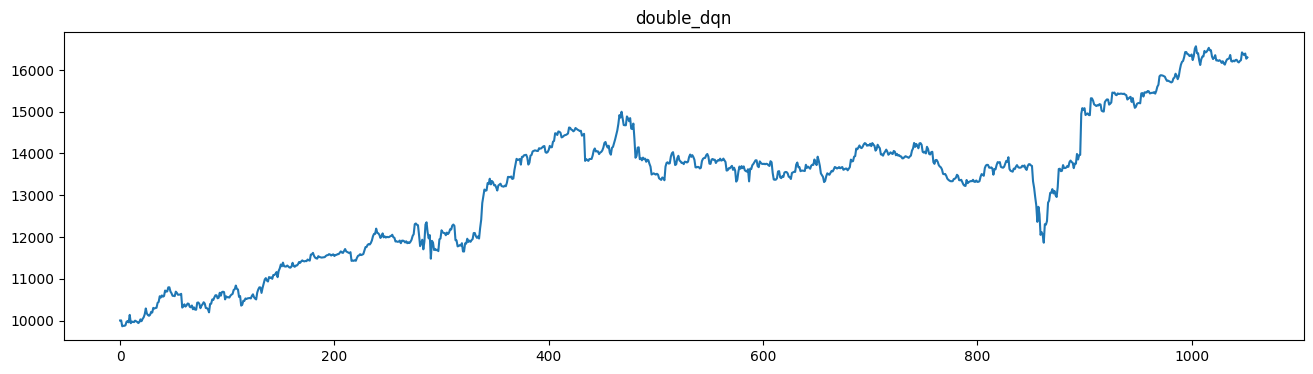

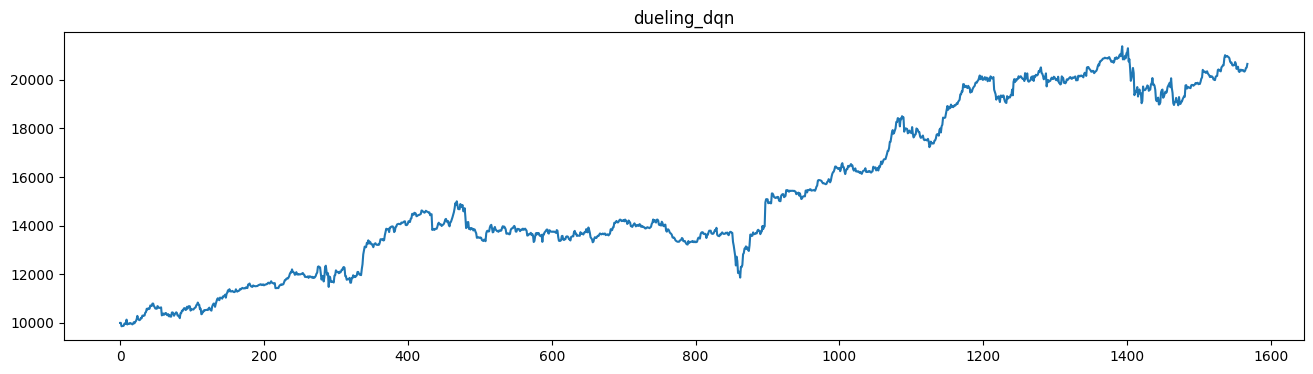

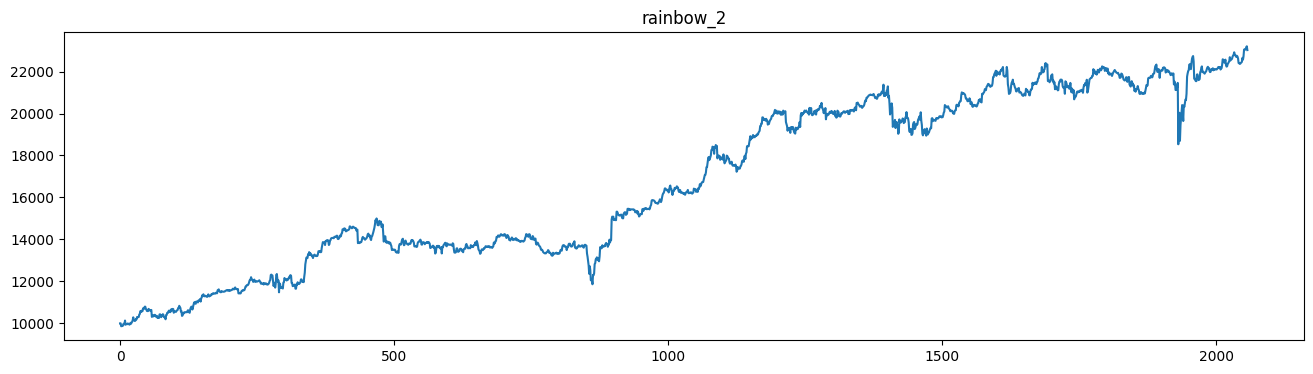

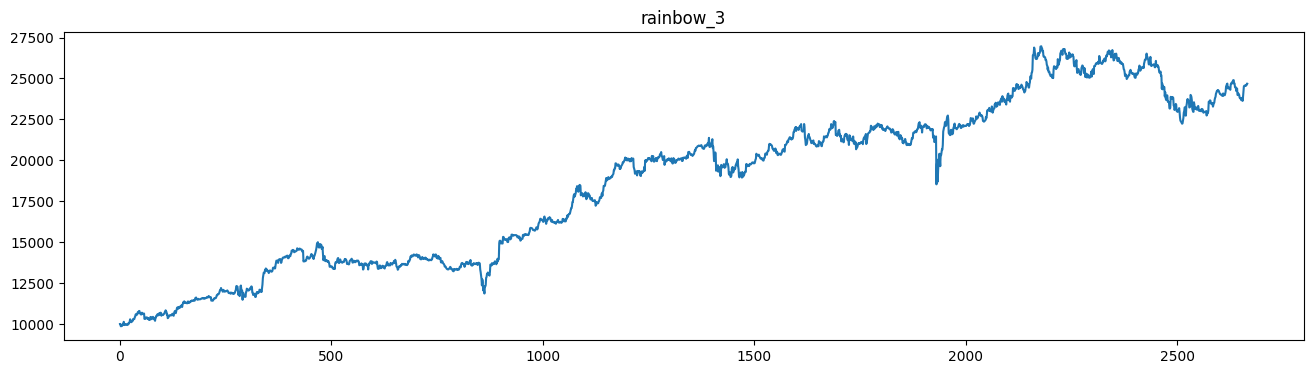

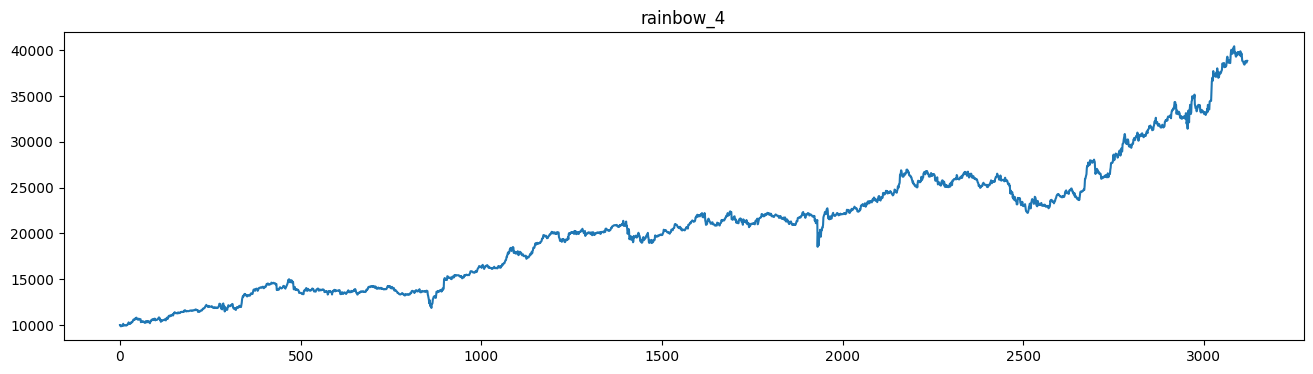

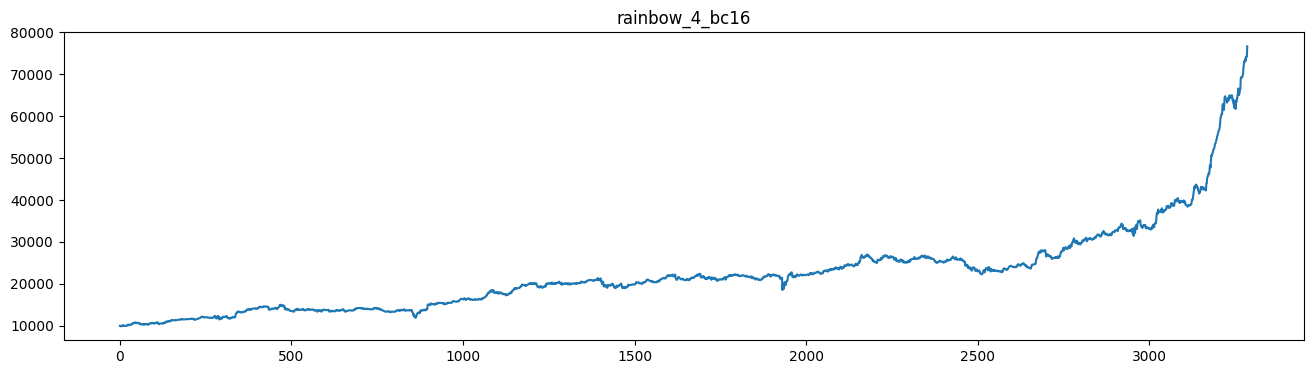

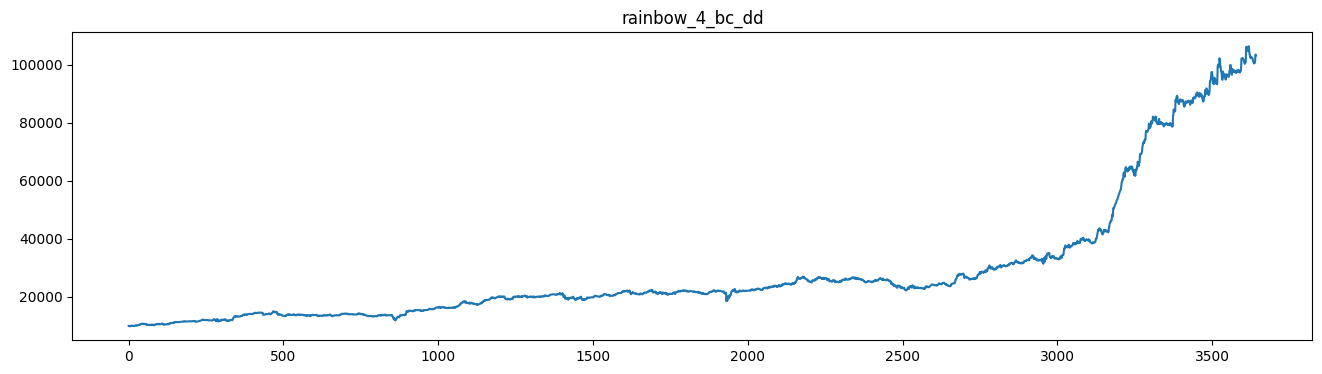

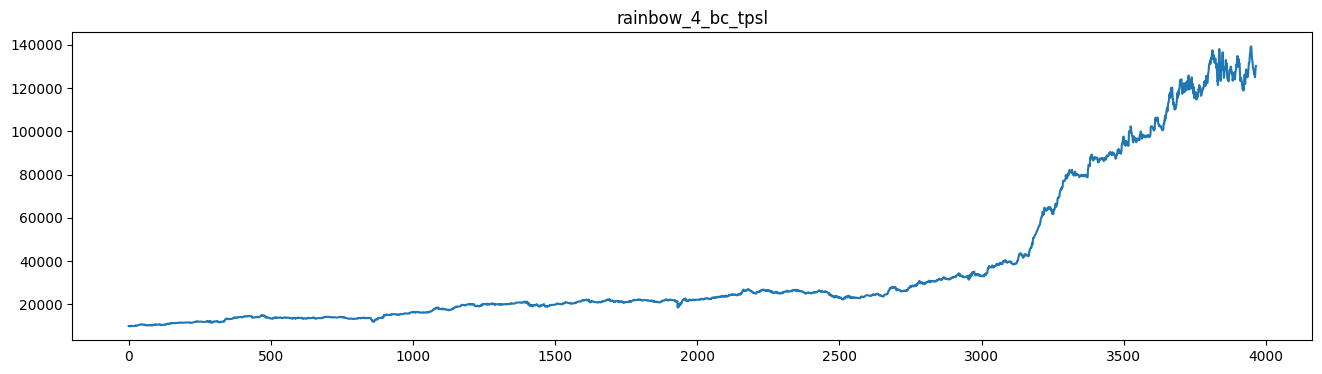

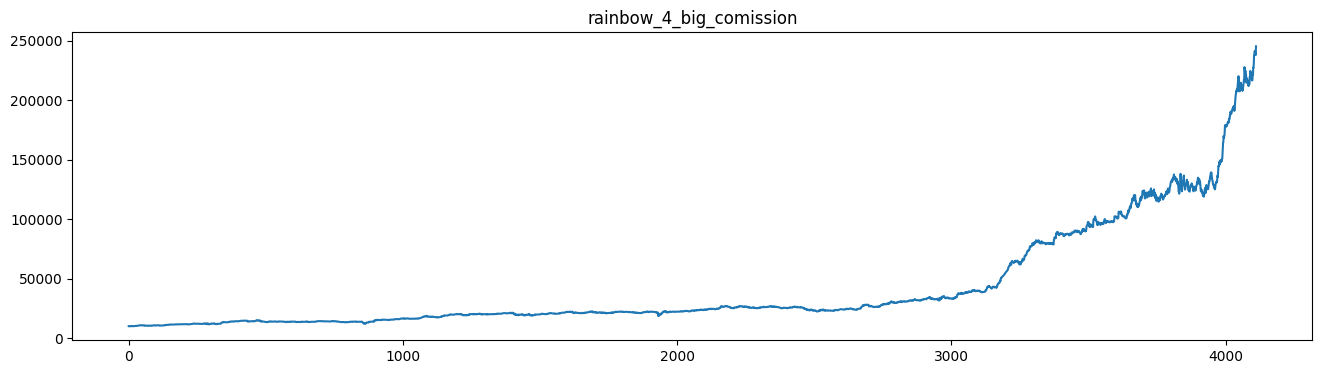

In [19]:
balance_arr = [10_000]
comis = 0.0002

for test_type in test_types:
    data[test_type] = data[test_type].reset_index(drop=True)
    for i in range(data[test_type].shape[0]):
        ep, cp = data[test_type].at[i, 'entry_price'], data[test_type].at[i, 'close_price']
        last_balance = balance_arr[-1]
        buy_c = last_balance // ep - 1
        last_balance -= buy_c * ep * (1 + comis)
        last_balance += buy_c * cp * (1 - comis)
        balance_arr.append(last_balance)
    
    plt.figure(figsize=(16,4))
    plt.title(test_type)
    plt.plot(balance_arr)

In [21]:
def dots_to_line(_df, dot_idx: np.array, line_col: str):
    _df[line_col] = np.nan
    _df.loc[dot_idx, line_col] = _df.loc[dot_idx, 'close']
    return _df

config = Config() 
test_type = 'rainbow_4_bc16'
deals_df = data[test_type]
price_df = pd.read_csv(config.data_path).iloc[:5000]

price_df = (price_df
    .pipe(lambda _df: dots_to_line(_df, dot_idx=deals_df.entry_step_i.values, line_col='entry_dots'))
    .pipe(lambda _df: dots_to_line(_df, dot_idx=deals_df.close_step_i.values, line_col='close_dots'))    
)

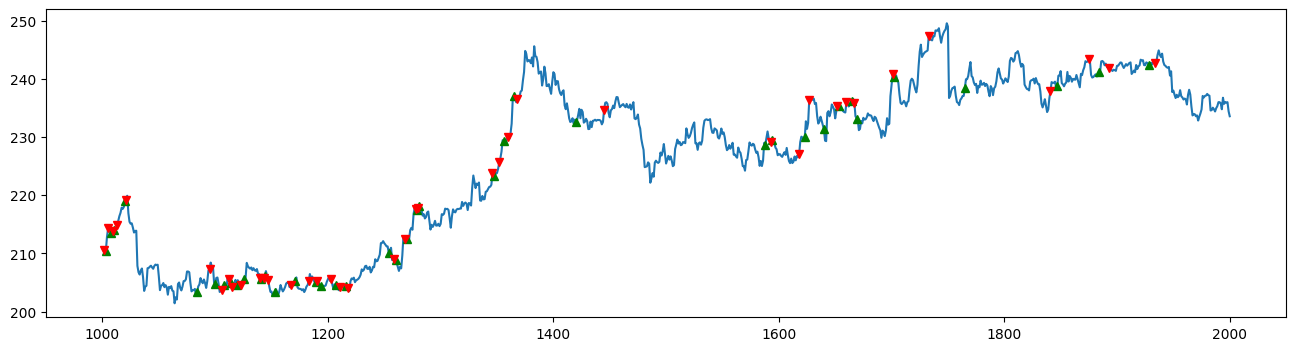

In [22]:
st, ed = 1000, 2000
plt.figure(figsize=(16,4))
plt.plot(price_df.loc[st:ed, 'close'])
plt.plot(price_df.loc[st:ed, 'entry_dots'], marker='^', color='g')
plt.plot(price_df.loc[st:ed, 'close_dots'], marker='v', color='r')